# Can we represent spectral lines with sparse tensors in PyTorch?

April 23-26, 2021   
Updated December 2021


gully


In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from blase.emulator import PhoenixEmulator
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
import numpy as np
from tqdm.notebook import tqdm

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
device

'cpu'

### Make a tensor composed of $N_{lines}$ sparsely spaced spectral lines.

I have experimentally verified that this notebook works with up to 500,000 lines.  You may wish to turn off overplotting all the lines for $N_{lines}>500$.  Also, the amplitudes become unphysical and the spectrum can become negative because we are adding flux loss and not opacity.

In [4]:
spectrum = PHOENIXSpectrum(teff=4700, logg=4.5, wl_lo=8019, wl_hi=12845)
spectrum = spectrum.divide_by_blackbody()
spectrum = spectrum.normalize()
continuum_fit = spectrum.fit_continuum(polyorder=5)
spectrum = spectrum.divide(continuum_fit, handle_meta="ff")

In [5]:
active_lower, active_upper = 8079, 12785
line_threshold_lower, line_threshold_upper = 8049, 12815

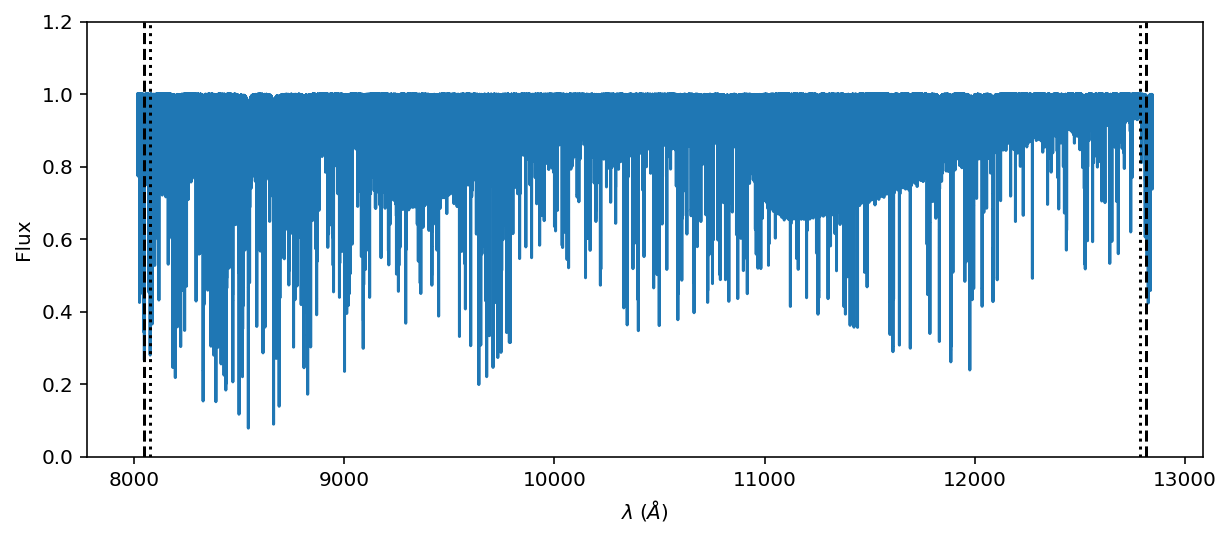

In [6]:
ax = spectrum.plot(ylo=0);
ax.axvline(8049, linestyle='dashed', color='k')
ax.axvline(12815, linestyle='dashed', color='k')

ax.axvline(8079, linestyle='dotted', color='k')
ax.axvline(12785, linestyle='dotted', color='k');

In [7]:
# Numpy arrays: 1 x N_pix
wl_native = spectrum.wavelength.value
flux_native = spectrum.flux.value

In [8]:
# Create the emulator
emulator = PhoenixEmulator(wl_native, flux_native, prominence=0.02)
emulator.to(device)

PhoenixEmulator()

### Make a buffer at the blue and red limits to deal with edge-effects

We include lines about 30 Å past the HPF red and blue limits, to handle RV shifts, line broadening, and line wings that lie outside the region of interest, but still affect the flux levels inside of it.

In [9]:
wl_0 = emulator.lam_centers.detach().numpy()

In [10]:
mask = (wl_0 > line_threshold_lower) & (wl_0 < line_threshold_upper)

In [11]:
wl_0 = wl_0[mask]
amplitudes = 5*np.exp(emulator.amplitudes.detach().numpy()[mask])
widths = np.exp(emulator.sigma_widths.detach().numpy()[mask])

You **can't run the line below** because it would max out the CPU and GPU RAM:

```python
with torch.no_grad():
    synthetic = emulator.forward(torch.tensor(wl_native))
```

Instead, we either break it into minibatches, or we use a *sparse* implementation.

## Sparse implementation

We need to define a **wing cut** around each spectral line.  Let's assume 30 Å.

In [12]:
n_pix = len(wl_native)

In [13]:
n_lines = len(wl_0)

In [14]:
n_pix, n_lines

(340349, 6489)

In [15]:
wing_cut_angstroms = 30

In [16]:
wing_cut_pixels = 6000

### Applying the wing cuts
There are a few standardization strategies for applying the wing cuts.  Here we coerce all wing cuts to be exactly 6000 pixels, with the middle pixel being at the line center position, and 3000 pixels to the red and blue side of the line.  Most spectral lines only appreciably affect the signal in the central $\sim5-50$ pixels, so such a large wing cut may seem over-zealous.  We emphasize that the line cut serves as the fixed pixel locations where the line will be evaluated with radial velocity shifts and line broadening.  So these 6000 pixels must be capable of handling the fastest-moving and fast-spinning stars you expect to see in your observed spectra of interest.  

The PHOENIX spectra double their pixel sampling shortward of $1 \mu$m, so 6000 pixels in the visible is about 30 Angstroms, but 6000 pixels in the infrared is about 60 Angstroms.  We *could have* demanded that the wingcut be exactly 30 Å, or some other heuristic, but that choice would result in *jagged* or *ragged* arrays: collections of 1D arrays that differ in their lengths.  Some lines would have 5999 pixels, some would have 6000, and others would have 2999 or 3000 pixels.  Most efficient CPU and GPU algorithms are not equipped to deal with ragged arrays, therefore increasing the computation time.  Instead, the choice of exactly 6000 pixels means we can use standard matrix or tensor arithmetic, which somewhat counterintuitively is faster and handles more pixels for all spectral lines: 6000 pixels everywhere is faster than 6000 pixels for some and 2999 for other lines.

Locating the indicies of these 6000 "nearest-neighbor" pixels takes about 0.01 seconds per spectral line, so for 6500 spectral lines the preprocessing step takes about 90 seconds.  **This initialization only occurs once and then is fixed,** so we should not worry too much that it is slow.  We could also conceive of heuristics to speed this up if we really cared.

In [17]:
list_of_nonzero_indices = []
for line_center in tqdm(wl_0):
    distance = np.abs(wl_native - line_center)
    these_pixels = np.argsort(distance)[0:wing_cut_pixels]
    list_of_nonzero_indices.append(sorted(these_pixels))

  0%|          | 0/6489 [00:00<?, ?it/s]

In [18]:
indices_2D = np.array(list_of_nonzero_indices)

In [19]:
indices_1D = indices_2D.reshape(-1)

In [20]:
indices_2D.shape, indices_1D.shape

((6489, 6000), (38934000,))

In [21]:
n_pix / wing_cut_pixels

56.724833333333336

With sparsity we should get about a 50x speedup, not to mention memory savings.

In [22]:
wl_2D = wl_native[indices_2D]

In [23]:
def log_gaussian(wl, amplitudes, lam_centers, sigmas):
    """Compute Gaussian assuming sparse 2D implementation"""
    return np.log(amplitudes) + (-0.5 * (wl-lam_centers)**2 / sigmas**2)

In [24]:
def gaussian(wl, amplitudes, lam_centers, sigmas):
    """Compute Gaussian assuming sparse 2D implementation"""
    return amplitudes * np.exp(-0.5 * (wl-lam_centers)**2 / sigmas**2)

In [25]:
flux_2D = gaussian(wl_2D, 
                   amplitudes[:, np.newaxis],
                   wl_0[:, np.newaxis],
                   widths[:, np.newaxis])

In [26]:
wl_1D, flux_1D = wl_2D.reshape(-1), flux_2D.reshape(-1)

### Construct the sparse Tensor

We hand in the index locations or "coordinates" of the non-zero pixels, the values at those coordinate locations, and the maximum extent of the sparse matrix (the total number of pixels in the spectrum).  We want to compute the *blase* product, Equation 1 in the paper:

$$F(\vec{\lambda}) = \prod_{i=1}^{N_{lines}} \left(1-V(\vec{\lambda};A_i, \lambda_{c,i}, \sigma_i) \right)$$

But a product of terms is the same the exponential of the sum-of-logs:

$$\ln{F(\vec{\lambda})} = \sum_{i=1}^{N_{lines}} \ln{\left(1-V(\vec{\lambda};A_i, \lambda_{c,i}, \sigma_i) \right)}$$

Sparse matrix methods generally support an operation known as **coalescing**, that sums values with repeated indices.    Each pixel gets computed on average about $\sim100$ times in this sparse implementation, which is about $50\times$ better than each pixel getting computed $N_{lines}\sim6500$ times in the dense approach.

In [27]:
ln_term = np.log(1-flux_1D)

In [28]:
indices = indices_1D[None, :]

In [29]:
sparse_matrix = torch.sparse_coo_tensor(indices, 
                                        ln_term, 
                                        size=(n_pix,),
                                        requires_grad=False)

In [30]:
result_1D = sparse_matrix.to_dense()

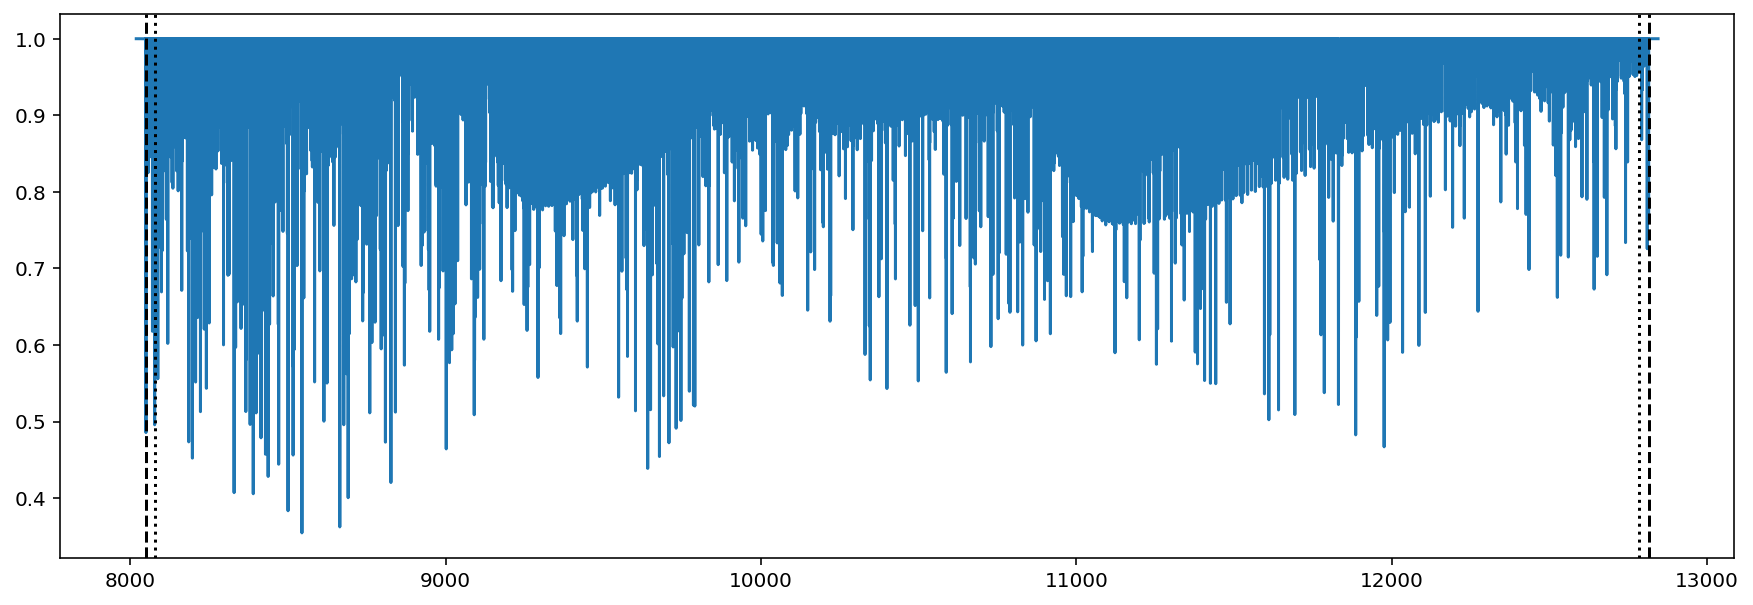

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(wl_native, np.exp(result_1D))

ax.axvline(8049, linestyle='dashed', color='k')
ax.axvline(12815, linestyle='dashed', color='k')

ax.axvline(8079, linestyle='dotted', color='k')
ax.axvline(12785, linestyle='dotted', color='k');

Voilà!  We computed the entire spectrum in one-fell-swoop with a sparse implementation.  That speed was infeasible with our previous fully-strided dense implementation.

Here we only illustrated Gaussian lines, but Lorentzian, Voigts, and Pseudo-Voigts should all work with no problem.

We have not illustrated whether the sparse approach can handle backpropagation, but based on the PyTorch documentation, we believe it should: `.coalesce()` and `.to_dense()` operations work with `requires_grad=True`.